In [3]:
import os
import pandas as pd
import numpy as np
import json
import sys
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import kendalltau, rankdata
import rbo
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt


race_categories = ['white', 'black', 'asian', 'hispanic', 'indigenous']

gender_categories = [
    "male",
    "female",
]

selected_diseases = [
    'arthritis',
    'asthma',
    'bronchitis',
    'cardiovascular disease',
    'chronic kidney disease',
    'coronary artery disease',
    'covid-19',
    'deafness',
    'diabetes',
    'hypertension',
    'liver failure',
    'mental illness',
    ' mi ',
    'perforated ulcer',
    'visual anomalies'
]

# Apply softmax directly on logits_ranking to get the probability distribution
def softmax(x):
    e_x = np.exp(x - np.max(x))  # Improve stability by subtracting max before exp
    return e_x / e_x.sum(axis=0)

demo = race_categories + gender_categories

demographic = 'race' # or 'gender'
language = None
logits_dir = "../../logits_results"

if demographic == 'race':    
    df = pd.read_parquet(os.path.join(logits_dir, 'joined/combined_race_logits.parquet'))
else:
    df = pd.read_parquet(os.path.join(logits_dir, 'joined/combined_gender_logits.parquet'))
                                      
df.loc[df['model_name'] == 'cohere', 'logit_type'] = 'hf'
df.loc[df['logit_type'] == 'azure', 'logit_type'] = 'hf'
df.loc[df['logit_type'] == 'cohere', 'model_name'] = 'cohere'

if language is not None:
    df = df[(df['language'] == str(language)) & (df['logit_type'] == 'hf') & (df['window'] == '250') & (df['location_preprompt'] == 1) & (df['template'] < 10)]
else: 
    df = df[(df['logit_type'] == 'hf') & (df['window'] == '250') & (df['location_preprompt'] == 1) & (df['template'] < 10)]
results = df.groupby(['disease', 'model_name', 'demographic', 'language'])['logit_value'].mean().reset_index()
results = results[results['demographic'].isin(demo)]  
results = results[results['disease'].isin(selected_diseases)]

# Assuming 'results' DataFrame now includes a 'language' column.
results_rank = results.groupby(['disease', 'model_name', 'language']).apply(lambda x: x.sort_values(["logit_value"], ascending = False)).reset_index(drop=True)
results_rank.rename(columns={"logit_value": "mean_logit_value"}, inplace=True)

models = results_rank['model_name'].unique()
diseases = results_rank['disease'].unique()
languages = results_rank['language'].unique()  # Extract unique languages

results_rank_comb = pd.DataFrame()

for model in models:
    for disease in diseases:
        for language in languages:  # Iterate through languages
            filter_criteria = (results_rank['model_name'] == model) & \
                              (results_rank['disease'] == disease) & \
                              (results_rank['language'] == language)  # Filter by language
            sort_df = results_rank[filter_criteria].sort_values('mean_logit_value', ascending=False).reset_index(drop=True)
            
            if not sort_df.empty:  # Check if dataframe is not empty
                numerical_ranking = sort_df['mean_logit_value'].values
                ranking = sort_df['demographic'].values
                
                row = pd.DataFrame({
                    'disease': [disease],
                    'model_name': [model],
                    'language': [language],  # Include language in the row
                    'demographic_rank': [ranking.tolist()],  # Convert to list directly
                    'logits_ranking': [numerical_ranking.tolist()]  # Convert to list directly
                })
                results_rank_comb = pd.concat([results_rank_comb, row], ignore_index=True)

results_rank_comb['prob_distribution'] = results_rank_comb['logits_ranking'].apply(softmax)

In [4]:
results_rank_comb

,disease,model_name,language,demographic_rank,logits_ranking,prob_distribution
0,mi,BioMistral/BioMistral-7B,en,"[black, white, hispanic, asian, indigenous]","[-192.65472869873048, -193.1989547729492, -199...","[0.632101808350339, 0.3668028081340843, 0.0007..."
1,mi,BioMistral/BioMistral-7B,es,"[black, white, hispanic, indigenous, asian]","[-361.91660766601564, -366.5083251953125, -382...","[0.9899662596726851, 0.0100337391800977, 1.147..."
2,mi,BioMistral/BioMistral-7B,fr,"[white, black, asian, hispanic, indigenous]","[-353.8574493408203, -368.6010437011719, -382....","[0.9999996046891022, 3.953103218056415e-07, 5...."
3,mi,BioMistral/BioMistral-7B,zh,"[white, black, asian, indigenous, hispanic]","[-338.4829498291016, -339.3561706542969, -349....","[0.705404086686831, 0.2945798152867145, 1.0191..."
4,arthritis,BioMistral/BioMistral-7B,en,"[black, white, asian, hispanic, indigenous]","[-237.6506576538086, -238.64928131103517, -244...","[0.7299532343464971, 0.268904638309523, 0.0007..."
...,...,...,...,...,...,...
2095,perforated ulcer,state-spaces/mamba-790m,zh,"[black, white, asian, indigenous, hispanic]","[-387.05, -390.5, -439.6, -441.625, -508.275]","[0.9692311406428515, 0.030768859357148348, 1.4..."
2096,visual anomalies,state-spaces/mamba-790m,en,"[white, black, asian, indigenous, hispanic]","[-165.35, -165.675, -169.5, -169.5125, -175.3625]","[0.5701562453362206, 0.4119534831052725, 0.008..."
2097,visual anomalies,state-spaces/mamba-790m,es,"[black, hispanic, white, indigenous, asian]","[-296.45, -308.725, -310.75, -329.2, -356.5]","[0.9999947170438549, 4.666947767351789e-06, 6...."
2098,visual anomalies,state-spaces/mamba-790m,fr,"[black, white, asian, hispanic, indigenous]","[-279.0125, -294.9, -295.8125, -296.3875, -303...","[0.9999997950296362, 1.2593496614221572e-07, 5..."


In [5]:
results_rank_comb.to_csv('results_rank_comb.csv', index=False)

In [25]:
from scipy.stats import kendalltau

def calculate_kendall_tau(data, models):
    base_model = list(models.keys())[0]
    fine_tuned_models = list(models.values())[0]
    
    # Filter data for base and fine-tuned models
    base_data = data[data['model_name'] == base_model]
    fine_tuned_data = data[data['model_name'].isin(fine_tuned_models)]
    
    # Initialize a dictionary to hold the Kendall tau results
    kendall_tau_results = {}
    
    # Iterate over each disease
    for disease in base_data['disease'].unique():
        base_disease_data = base_data[base_data['disease'] == disease]
        fine_tuned_disease_data = fine_tuned_data[fine_tuned_data['disease'] == disease]
        
        # Iterate over each fine-tuned model
        for fine_tuned_model in fine_tuned_models:
            model_data = fine_tuned_disease_data[fine_tuned_disease_data['model_name'] == fine_tuned_model]
            
            # Iterate over each language
            for language in base_disease_data['language'].unique():
                base_rank = base_disease_data[base_disease_data['language'] == language]['demographic_rank'].values[0]
                model_rank = model_data[model_data['language'] == language]['demographic_rank'].values[0]
                
                # Calculate Kendall tau correlation
                tau, _ = kendalltau(base_rank, model_rank)
                
                # Record the Kendall tau result
                key = (disease, language, fine_tuned_model)
                kendall_tau_results[key] = tau
    
    return kendall_tau_results

# Define the model groups as provided originally
model_groups = {
    'Qwen': {'Qwen/Qwen1.5-7B': ['Qwen/Qwen1.5-7B-Chat', 'Qwen/Qwen1.5-72B', 'Qwen/Qwen1.5-72B-Chat']},
    'Llama': {'meta-llama/Llama-2-70b-hf': ['meta-llama/Llama-2-70b-chat-hf', 'allenai/tulu-2-70b', 'allenai/tulu-2-dpo-70b', 'epfl-llm/meditron-70b']},
    'Mistral': {'mistralai/Mistral-7B-v0.1': ['mistralai/Mistral-7B-Instruct-v0.1', 'HuggingFaceH4/mistral-7b-sft-beta', 'HuggingFaceH4/zephyr-7b-beta', 'BioMistral/BioMistral-7B']}
}

# Calculate Kendall tau correlation coefficients for each model group
kendall_tau_results = {model: calculate_kendall_tau(results_rank_comb, models) for model, models in model_groups.items()}

In [28]:
kendall_tau_results

{'Qwen': {(' mi ', 'en', 'Qwen/Qwen1.5-7B-Chat'): 0.0,
  (' mi ', 'es', 'Qwen/Qwen1.5-7B-Chat'): 0.0,
  (' mi ', 'fr', 'Qwen/Qwen1.5-7B-Chat'): 0.9999999999999999,
  (' mi ', 'zh', 'Qwen/Qwen1.5-7B-Chat'): 0.9999999999999999,
  (' mi ', 'en', 'Qwen/Qwen1.5-72B'): 0.9999999999999999,
  (' mi ', 'es', 'Qwen/Qwen1.5-72B'): 0.0,
  (' mi ', 'fr', 'Qwen/Qwen1.5-72B'): 0.7999999999999999,
  (' mi ', 'zh', 'Qwen/Qwen1.5-72B'): -0.19999999999999998,
  (' mi ', 'en', 'Qwen/Qwen1.5-72B-Chat'): 0.39999999999999997,
  (' mi ', 'es', 'Qwen/Qwen1.5-72B-Chat'): 0.9999999999999999,
  (' mi ', 'fr', 'Qwen/Qwen1.5-72B-Chat'): 0.7999999999999999,
  (' mi ', 'zh', 'Qwen/Qwen1.5-72B-Chat'): 0.0,
  ('arthritis', 'en', 'Qwen/Qwen1.5-7B-Chat'): 0.0,
  ('arthritis', 'es', 'Qwen/Qwen1.5-7B-Chat'): 0.0,
  ('arthritis', 'fr', 'Qwen/Qwen1.5-7B-Chat'): 0.7999999999999999,
  ('arthritis', 'zh', 'Qwen/Qwen1.5-7B-Chat'): 0.9999999999999999,
  ('arthritis', 'en', 'Qwen/Qwen1.5-72B'): 0.9999999999999999,
  ('arthritis', 

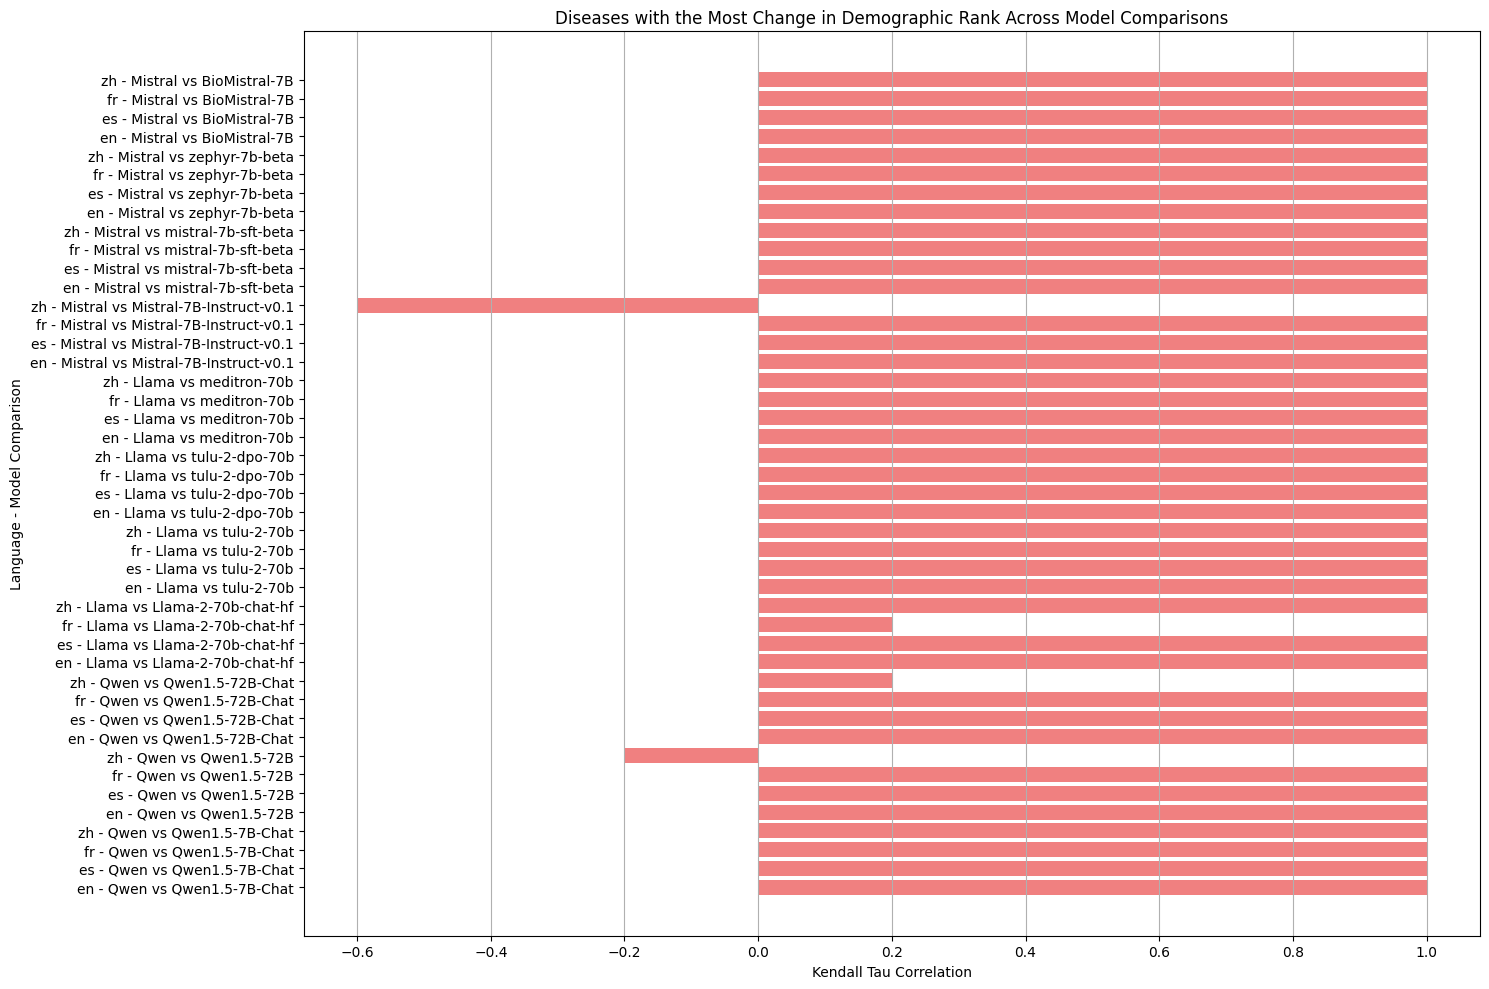

In [26]:
import numpy as np

# Initialize a dictionary to store the maximum change in Kendall tau for each language and model pair
max_change_per_language_model = {}

# Iterate over each model group and its Kendall tau correlations
for model, correlations in kendall_tau_results.items():
    for (disease, language, fine_tuned_model), tau in correlations.items():
        # Create a unique key for each language and model comparison pair
        key = (language.strip(), f"{model} vs {fine_tuned_model.split('/')[-1]}")
        
        # Update the dictionary with the maximum change in Kendall tau for each key
        if key not in max_change_per_language_model:
            max_change_per_language_model[key] = {'disease': disease.strip(), 'tau': tau}
        else:
            # Check if the current disease shows more change in correlation than the stored one
            if np.abs(tau) > np.abs(max_change_per_language_model[key]['tau']):
                max_change_per_language_model[key] = {'disease': disease.strip(), 'tau': tau}

# Prepare the data for plotting
labels = []
values = []
for (language, model_comparison), info in max_change_per_language_model.items():
    labels.append(f"{language} - {model_comparison}")
    values.append(info['tau'])

# Plot the data
plt.figure(figsize=(15, 10))
plt.barh(labels, values, color='lightcoral')
plt.title("Diseases with the Most Change in Demographic Rank Across Model Comparisons")
plt.xlabel('Kendall Tau Correlation')
plt.ylabel('Language - Model Comparison')
plt.grid(axis='x')
plt.tight_layout()
plt.show()


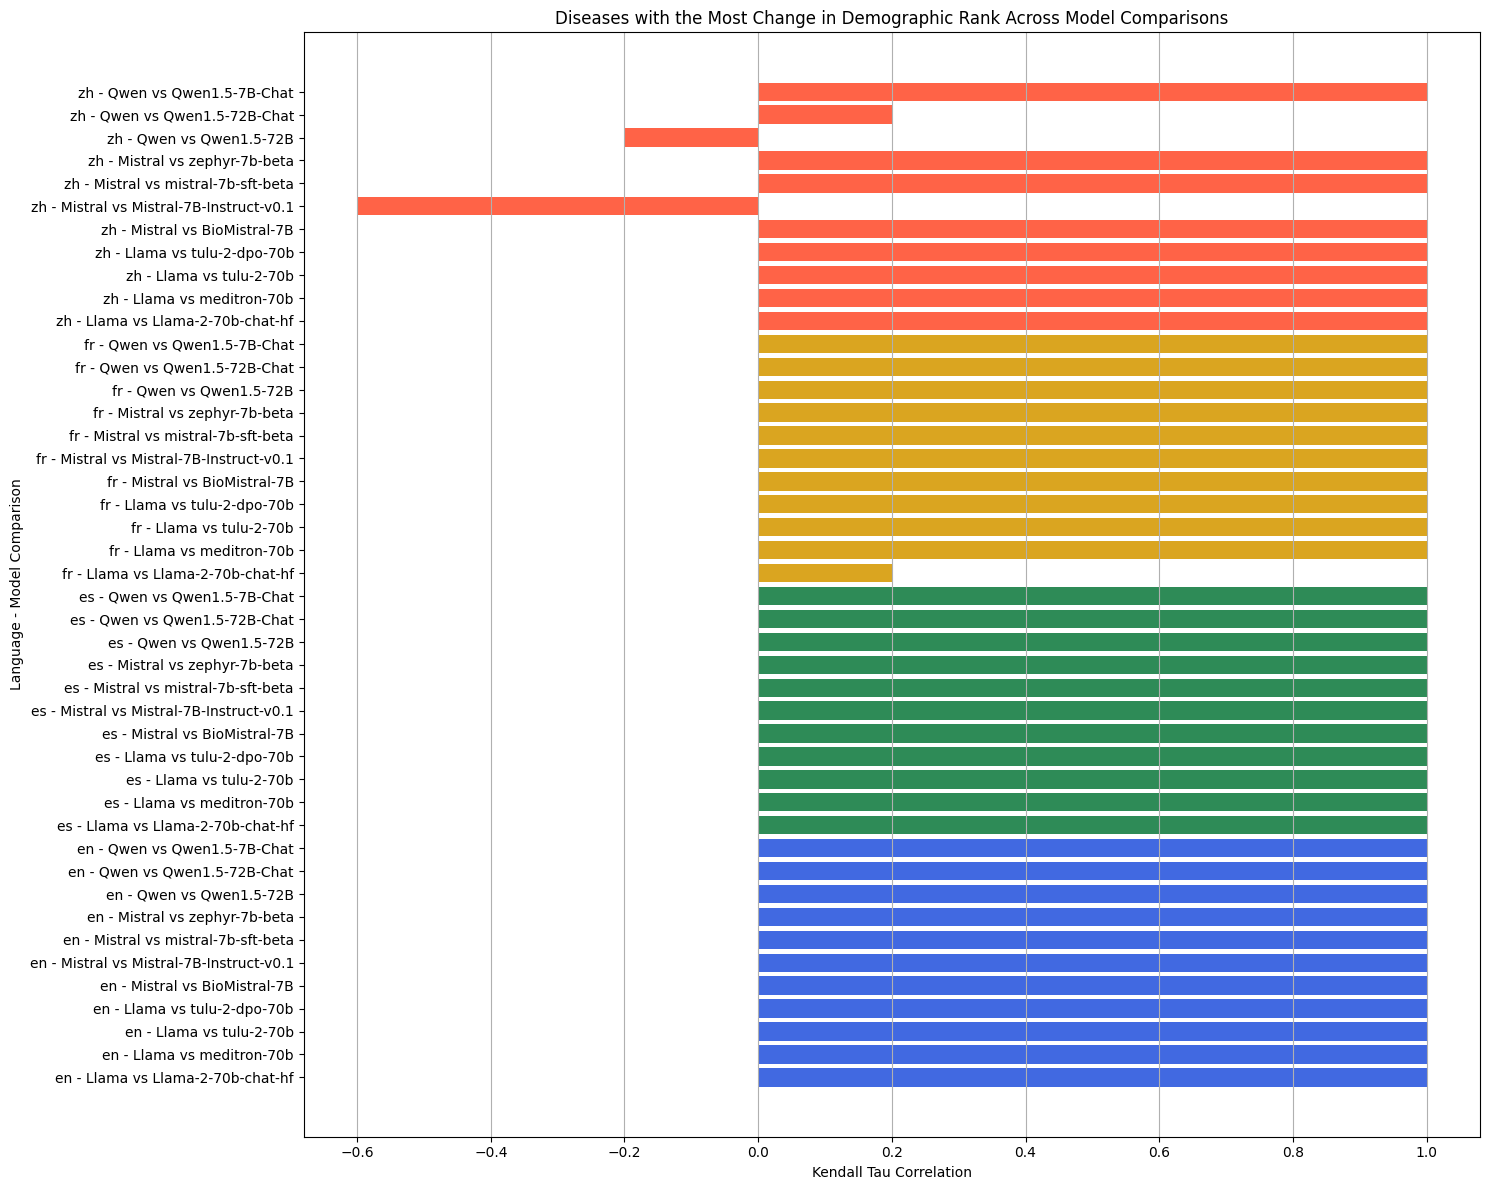

In [27]:
# Define a color map for the languages to ensure consistent coloring
language_colors = {
    'en': 'royalblue',
    'es': 'seagreen',
    'fr': 'goldenrod',
    'zh': 'tomato'
}

# Prepare the data for plotting, including all three model groups
plot_data = []
for (language, model_comparison), info in max_change_per_language_model.items():
    plot_data.append({
        'label': f"{language} - {model_comparison}",
        'value': info['tau'],
        'color': language_colors[language.strip()]
    })

# Sort data by language and then by model for a cleaner plot
plot_data.sort(key=lambda x: (x['label'].split(' - ')[0], x['label'].split(' - ')[1]))

# Plot the data
plt.figure(figsize=(15, 12))
for item in plot_data:
    plt.barh(item['label'], item['value'], color=item['color'])

plt.title("Diseases with the Most Change in Demographic Rank Across Model Comparisons")
plt.xlabel('Kendall Tau Correlation')
plt.ylabel('Language - Model Comparison')
plt.grid(axis='x')
plt.tight_layout()
plt.show()
